In [103]:
import os 
import sys 
import numpy as np 
import random 
import argparse
import cv2
import matplotlib.pyplot as plt
import pickle
import pylab as pl
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.cluster import KMeans

from skimage.feature import hog
from skimage import exposure


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC

np.random.seed(42)

In [2]:
data_dir = './data/'
class_list = ['Batman', 'Spiderman', 'None']


Width = 256
Height = 512

In [3]:
def get_file_names(path):
    return [os.path.join(path,f) for f in os.listdir(path)]

In [4]:
! ls

LICENSE                    classifier_prototype.ipynb
Output.txt                 data
README.md                  data_svm.dat
__pycache__                dataset
best_param_limmited.pkl    image_preprocessing.ipynb


In [5]:
image_paths = {}
for training_name in class_list:
    dir_= os.path.join(data_dir, training_name)
    class_path = get_file_names(dir_)
    image_paths[training_name] = class_path

In [6]:
label_dict = {'Batman':0, 'Spiderman':1, 'None':2}
image_data = []
for k, v in image_paths.items():
    for im in v: 
        image_data.append((im, label_dict[k]))

In [7]:
np.random.shuffle(image_data)
image_paths, labels = zip(*image_data)

In [190]:
des_list=[]
# hog = cv2.HOGDescriptor()

# https://stackoverflow.com/questions/44972099/opencv-hog-features-explanation
# https://answers.opencv.org/question/86023/what-is-the-hog-descriptors-shape/
#

for path in image_paths:
    img = cv2.imread(path)
    resized_image = []
    for i in range(3): 
        resized_image.append(cv2.resize(img[:,:,i], (256,512)))
#     resized_image = np.array(resized_image).reshape(128,64,3)
    resized_image = np.transpose(np.array(resized_image), (1, 2, 0))
    #creating hog features 
    descriptor, hog_image = hog(resized_image, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), visualize=True,channel_axis = -1,feature_vector= False)
#     descriptor = hog.compute(resized_image)
    des_list.append((path,np.array(descriptor)))

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


In [138]:
img = cv2.imread(path)
resized_image = []
for i in range(3): 
    resized_image.append(cv2.resize(img[:,:,i], (256,512)))
resized_image = np.transpose(np.array(resized_image), (1, 2, 0))# .reshape(512,256,3)

In [139]:
resized_image.shape

(512, 256, 3)

In [141]:
# descriptor = hog.compute(resized_image)

In [142]:
descriptor.shape

(578340,)

In [188]:
fd, hog_image = hog(resized_image, orientations=9, pixels_per_cell=(8, 8), 
                    cells_per_block=(2, 2), visualize=True,channel_axis = -1,feature_vector= False)

In [189]:
fd.shape

(63, 31, 2, 2, 9)

In [144]:
# n_blocks_row, n_blocks_col, n_cells_row, n_cells_col, n_orient

256/8,512/8,2,2,9

(32.0, 64.0, 2, 2, 9)

In [186]:
fd.reshape(31, 63, 4, -1).shape #.shape

(31, 63, 4, 9)

In [148]:
np.mean(np.mean(fd.reshape(31, 63, 4, -1),axis =-1),axis =-1).shape

(31, 63)

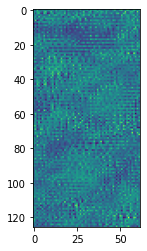

In [182]:

#Show the image with matplotlib
plt.imshow(fd.reshape(126, 62, -1).mean(axis=-1))
plt.show()

In [181]:
70308/9/4/63/31

1.0

In [184]:
hog_image.shape

(512, 256)

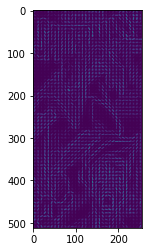

In [183]:
hog_image


#Show the image with matplotlib
plt.imshow(hog_image)
plt.show()


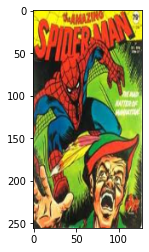

In [133]:

#Show the image with matplotlib
plt.imshow(resized_image[:,:,::-1])
plt.show()


# cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [100]:
path.split('/')[2]

'Spiderman'

In [191]:
reshaped_features = []
image_labels = []
BoW = []
BoW_labels = [] 
for i in range(len(des_list)): 
    temp_des = des_list[i][1]
    reshaped_features.append(temp_des.reshape(63 * 31,-1))
    image_labels.append(label_dict[des_list[i][0].split('/')[2]])
    for j in range(reshaped_features[i].shape[0]):
        BoW.append(reshaped_features[i][j])
        BoW_labels.append(des_list[i][0].split('/')[2])

In [192]:
BoW_array = np.array(BoW)

In [193]:
BoW_array.shape

(419895, 36)

In [232]:
def build_histogram(descriptor_list, cluster_alg):
    histogram = np.zeros(len(cluster_alg.cluster_centers_))
    cluster_result =  cluster_alg.predict(descriptor_list)
    for i in cluster_result:
        histogram[i] += 1.0
    return histogram

kmeans = KMeans(n_clusters = 100)
kmeans.fit(BoW_array)

preprocessed_image = []

for descriptor in reshaped_features:
    if (descriptor is not None):
        temp_features = []
        for piece in descriptor: 
            histogram = build_histogram(piece.reshape(1,-1), kmeans)  # getting histogram for each piece 
            temp_features.append(histogram)
        temp_features = np.sum(np.array(temp_features), 0)
        preprocessed_image.append(temp_features.reshape(-1,))

In [235]:
preprocessed_image[0].shape

(100,)

In [263]:
x_train, x_test, y_train, y_test = train_test_split(preprocessed_image, image_labels,
                                                    test_size = .3, random_state = 12)


In [264]:
grid = { 
    'C': [2**(-5), 2**(-4), 2**(-3), 2**(-2), 2**(-1), 1, 2, 4 ,8 ,16],
    'kernel': ['linear', 'poly', 'rbf'],
}

# grid = { 
#     'C': [2**(-5),  2**(-3), 1, 4 ,16],
#     'kernel': ['linear', 'rbf'],
# }

In [272]:
svm_cv = GridSearchCV(estimator=SVC(), param_grid=grid, cv= 5)
svm_cv.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.03125, 0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8,
                               16],
                         'kernel': ['linear', 'poly', 'rbf']})

In [273]:
print(svm_cv.best_params_)
best_param = svm_cv.best_params_

{'C': 2, 'kernel': 'rbf'}


In [274]:
pickle_file_name = 'best_param_limmited.pkl'
with open(pickle_file_name, 'wb') as handle:
    pickle.dump(svm_cv.best_params_, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [275]:
pickle_file_name = 'best_param_limmited.pkl'
if os.path.exists(pickle_file_name):
    with open(pickle_file_name, 'rb') as handle:
        best_param = pickle.load(handle)

In [276]:
svm_clf = SVC(**best_param)
svm_clf.fit(x_train, y_train)

SVC(C=2)

In [277]:
y_pred = svm_clf.predict(x_test)

In [278]:
accuracy_score(y_test, y_pred)

0.5692307692307692